# Imports, functions and Initial Setup

Importing necessary libraries used for recommendation modeling and data preprocessing.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

## Functions

### Functions for initial setup 

The function `load_data` loads the MovieLens dataset from a specified CSV file created in the EDA.

In [28]:
def load_and_preprocess_data(filepath='Datasets/combined_ratings.csv', verbose=True):
    """
    Load and preprocess the MovieLens dataset
    """
    ratings = pd.read_csv(filepath)
    if verbose:
        print(f"Original shape: {ratings.shape}")
        print(f"Number of unique users: {ratings['UserID'].nunique()}")
        print(f"Number of unique movies: {ratings['MovieID'].nunique()}")
        print(f"Average ratings per user: {ratings.groupby('UserID')['Rating'].count().mean():.2f}")
        print(f"Average ratings per movie: {ratings.groupby('MovieID')['Rating'].count().mean():.2f}")
    return ratings

The function `filter_data` filters the input `ratings` DataFrame by removing users and movies that have too few ratings. It retains only those users who have rated at least `min_user_ratings` movies and movies that have been rated by at least `min_movie_ratings` users. This helps reduce data sparsity and ensures that the resulting dataset is more robust for analysis or modeling. The function also outputs summary statistics about the filtering process, including the number of removed users, movies, ratings, and the density of the resulting matrix.

In [3]:
def filter_data(ratings, min_user_ratings=44, min_movie_ratings=50, verbose=True):
    """
    Filter out users and movies with too few ratings
    """
    # Get counts before filtering
    n_users_before = ratings['UserID'].nunique()
    n_movies_before = ratings['MovieID'].nunique()
    n_ratings_before = len(ratings)
    
    # Filter users and movies with too few ratings
    user_counts = ratings['UserID'].value_counts()
    movie_counts = ratings['MovieID'].value_counts()
    
    filtered_ratings = ratings[ratings['UserID'].isin(user_counts[user_counts >= min_user_ratings].index)]
    filtered_ratings = filtered_ratings[filtered_ratings['MovieID'].isin(movie_counts[movie_counts >= min_movie_ratings].index)]
    
    if verbose:
        print(f"Filtered shape: {filtered_ratings.shape}")
        print(f"Removed {n_users_before - filtered_ratings['UserID'].nunique()} users")
        print(f"Removed {n_movies_before - filtered_ratings['MovieID'].nunique()} movies")
        print(f"Removed {n_ratings_before - len(filtered_ratings)} ratings")
        print(f"Density: {len(filtered_ratings) / (filtered_ratings['UserID'].nunique() * filtered_ratings['MovieID'].nunique()) * 100:.2f}%")
    
    return filtered_ratings

The function `feature_engineering` enhances the `ratings` DataFrame by applying normalization techniques and extracting additional features. Depending on the selected method (`mean_centering`, `z_score`, or `min_max`), it normalizes user ratings to account for individual rating behavior. It also extracts user demographic information such as gender, age, and occupation into a separate DataFrame. If timestamp data is available, the function adds temporal features including day of the week, month, and year. These engineered features are useful for improving the performance of recommendation models or for exploratory data analysis.

In [4]:
def feature_engineering(ratings, normalization='mean_centering'):
    """
    Apply feature engineering to ratings data
    """
    # Normalize ratings per user
    if normalization == 'mean_centering':
        ratings['Rating_normalized'] = ratings.groupby('UserID')['Rating'].transform(lambda x: x - x.mean())
    elif normalization == 'z_score':
        ratings['Rating_normalized'] = ratings.groupby('UserID')['Rating'].transform(lambda x: (x - x.mean()) / x.std())
    elif normalization == 'min_max':
        ratings['Rating_normalized'] = ratings.groupby('UserID')['Rating'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    else:  # No normalization
        ratings['Rating_normalized'] = ratings['Rating']
    
    # Create user demographic features
    user_features = ratings[['UserID', 'Gender', 'Age', 'Occupation']].drop_duplicates().set_index('UserID')
    
    # Add timestamp features if available
    if 'Timestamp' in ratings.columns:
        ratings['TimestampDT'] = pd.to_datetime(ratings['Timestamp'], unit='s')
        ratings['DayOfWeek'] = ratings['TimestampDT'].dt.dayofweek
        ratings['Month'] = ratings['TimestampDT'].dt.month
        ratings['Year'] = ratings['TimestampDT'].dt.year
    
    return ratings, user_features

The function `create_user_item_matrix` transforms the `ratings` DataFrame into a user-item matrix, where each row corresponds to a user, each column corresponds to a movie, and the cell values represent the normalized ratings given by users. This matrix is essential for collaborative filtering techniques and other recommendation algorithms. The function also prints the shape of the matrix and calculates its sparsity, indicating how many of the possible user-movie interactions are missing. High sparsity is common in real-world recommendation systems and can influence the choice of modeling approach.

In [5]:
def create_user_item_matrix(ratings):
    """
    Create user-item matrix from ratings data
    """
    user_item_matrix = ratings.pivot_table(index='UserID', columns='MovieID', values='Rating_normalized')
    print(f"User-item matrix shape: {user_item_matrix.shape}")
    
    # Calculate sparsity
    sparsity = 1 - (np.count_nonzero(~np.isnan(user_item_matrix)) / (user_item_matrix.shape[0] * user_item_matrix.shape[1]))
    print(f"Matrix sparsity: {sparsity*100:.2f}%")
    
    return user_item_matrix

The function `train_test_split` divides the user-item matrix into separate training and test sets on a per-user basis. For each user with at least 5 ratings, a random subset of their ratings is assigned to the training set, while the remaining ratings are allocated to the test set, based on the specified `test_size` ratio. This approach ensures that each user's preferences are represented in both sets. The function returns the training and test matrices in wide format, as well as a long-format test set for easier evaluation. It also prints the number and percentage of ratings in each split, providing insight into the distribution of data.

In [6]:
def train_test_split(user_item_matrix, test_size=0.2, random_state=42):
    """
    Split data into train and test sets per user
    """
    train_matrix = user_item_matrix.copy() * np.nan
    test_matrix = user_item_matrix.copy() * np.nan
    
    for user_id in user_item_matrix.index:
        user_ratings = user_item_matrix.loc[user_id].dropna()
        if len(user_ratings) < 5:  # Skip users with less than 5 ratings
            continue
        shuffled = user_ratings.sample(frac=1, random_state=random_state)
        cutoff = int((1 - test_size) * len(shuffled))
        train_matrix.loc[user_id, shuffled.index[:cutoff]] = shuffled.values[:cutoff]
        test_matrix.loc[user_id, shuffled.index[cutoff:]] = shuffled.values[cutoff:]
    
    # Convert to long format for easier handling
    test_long = test_matrix.stack().reset_index()
    test_long.columns = ['UserID', 'MovieID', 'Rating']
    
    # Print split info
    train_count = train_matrix.count().sum()
    test_count = test_matrix.count().sum()
    print(f"Training set: {train_count} ratings ({train_count/(train_count+test_count)*100:.1f}%)")
    print(f"Test set: {test_count} ratings ({test_count/(train_count+test_count)*100:.1f}%)")
    
    return train_matrix, test_matrix, test_long

### Functions for UserKNN modelling

The function `compute_similarity` calculates a similarity matrix between users based on their rating patterns in the training data. It supports multiple similarity methods, including cosine similarity, Pearson correlation, and Jaccard similarity. Before computing similarity, missing values are filled with zeros. For Jaccard similarity, ratings are binarized to reflect whether an item was rated or not. The result is returned as a DataFrame where rows and columns represent users, and the cell values indicate the degree of similarity between each pair of users. This matrix is crucial for user-based collaborative filtering approaches.

In [7]:
def compute_similarity(train_matrix, similarity_method='cosine'):
    """
    Compute similarity matrix between users
    """
    # Fill NaNs for similarity calculation
    train_filled = train_matrix.fillna(0)
    
    if similarity_method == 'cosine':
        similarity_matrix = cosine_similarity(train_filled)
    elif similarity_method == 'pearson':
        similarity_matrix = 1 - pairwise_distances(train_filled, metric='correlation')
        # Replace NaNs (which can occur if a user has no variance)
        similarity_matrix = np.nan_to_num(similarity_matrix)
    elif similarity_method == 'jaccard':
        # Convert to binary matrix (rated or not rated)
        binary_matrix = (train_filled > 0).astype(int)
        similarity_matrix = 1 - pairwise_distances(binary_matrix, metric='jaccard')
    else:
        raise ValueError(f"Similarity method '{similarity_method}' not recognized")
    
    # Convert to DataFrame for easier indexing
    similarity_df = pd.DataFrame(
        similarity_matrix, 
        index=train_filled.index, 
        columns=train_filled.index
    )
    
    return similarity_df

The function `predict_rating` estimates the rating a specific user would give to a specific item using user-based collaborative filtering. It identifies other users who have rated the same item and calculates their similarity to the target user. Based on the top `k` most similar users (optionally filtered by a minimum similarity threshold), it computes a weighted average of their ratings for the item, using the similarity scores as weights. If insufficient data is available—such as no similar users or no ratings—it returns `NaN`. This function is essential for generating personalized recommendations.

In [8]:
def predict_rating(user_id, item_id, similarity_df, train_matrix, k=30, min_similarity=0):
    """
    Predict rating for a given user-item pair using user-based collaborative filtering
    """
    # Check if user_id and item_id exist in our data
    if user_id not in similarity_df.index or item_id not in train_matrix.columns:
        return np.nan
    
    # Get users who rated this item
    users_who_rated = train_matrix[item_id].dropna().index
    
    # Get similarity scores for these users
    if len(users_who_rated) == 0:
        return np.nan
    
    # Get similarities for users who rated this item
    sim_scores = similarity_df.loc[user_id, users_who_rated]
    
    # Filter by minimum similarity if needed
    if min_similarity > 0:
        sim_scores = sim_scores[sim_scores >= min_similarity]
    
    # If no similar users remain, return nan
    if len(sim_scores) == 0:
        return np.nan
    
    # Get top k most similar users
    top_k_users = sim_scores.nlargest(k).index
    
    # Get ratings from these users for this item
    top_k_ratings = train_matrix.loc[top_k_users, item_id]
    
    # Filter out NaN values
    top_k_ratings = top_k_ratings.dropna()
    
    # If no ratings remain, return nan
    if len(top_k_ratings) == 0:
        return np.nan
    
    # Get similarity scores for users with ratings
    top_k_sims = similarity_df.loc[user_id, top_k_ratings.index]
    
    # Calculate weighted average of ratings
    weighted_sum = (top_k_ratings * top_k_sims).sum()
    sim_sum = top_k_sims.sum()
    
    if sim_sum == 0:
        return np.nan
    
    # Return weighted average
    return weighted_sum / sim_sum

The function `tune_hyperparameters` performs a grid search to identify the optimal values for `k` (number of neighbors) and `min_similarity` (minimum similarity threshold) used in the `predict_rating` function. It evaluates different combinations of these hyperparameters by predicting a sample of ratings from the test set and calculating evaluation metrics such as RMSE, MAE, and prediction coverage. A progress bar tracks the tuning process, and the best configuration is selected based on the lowest RMSE. The function returns a DataFrame with all results and highlights the best-performing parameter combination, helping to optimize recommendation accuracy.

In [9]:
def tune_hyperparameters(test_long, similarity_df, train_matrix, k_values=None, similarity_thresholds=None):
    """
    Perform grid search to find optimal hyperparameters
    """
    if k_values is None:
        k_values = list(range(5, 51, 5))
    
    if similarity_thresholds is None:
        similarity_thresholds = [0]  # By default, don't filter by similarity
    
    results = []
    
    print("Tuning hyperparameters...")
    # Progress bar for combinations
    total_combinations = len(k_values) * len(similarity_thresholds)
    progress_bar = tqdm(total=total_combinations)
    
    for k in k_values:
        for min_sim in similarity_thresholds:
            predictions = []
            actuals = []
            
            # Sample only a portion of test data for faster tuning if the dataset is large
            sample_size = min(10000, len(test_long))
            test_sample = test_long.sample(n=sample_size, random_state=42) if len(test_long) > sample_size else test_long
            
            for row in test_sample.itertuples(index=False):
                uid, iid, true_rating = row
                pred = predict_rating(uid, iid, similarity_df, train_matrix, k=k, min_similarity=min_sim)
                if not np.isnan(pred):
                    predictions.append(pred)
                    actuals.append(true_rating)
            
            if len(predictions) > 0:
                rmse = mean_squared_error(actuals, predictions, squared=False)
                mae = mean_absolute_error(actuals, predictions)
                coverage = len(predictions) / len(test_sample) * 100
                results.append((k, min_sim, rmse, mae, coverage))
                print(f"k={k}, min_sim={min_sim:.2f} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, Coverage: {coverage:.1f}%")
            else:
                print(f"k={k}, min_sim={min_sim:.2f} → No valid predictions")
            
            progress_bar.update(1)
    
    progress_bar.close()
    
    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(results, columns=['k', 'min_similarity', 'rmse', 'mae', 'coverage'])
    
    # Find best parameters based on RMSE
    best_idx = results_df['rmse'].idxmin()
    best_k = results_df.loc[best_idx, 'k']
    best_min_sim = results_df.loc[best_idx, 'min_similarity']
    best_rmse = results_df.loc[best_idx, 'rmse']
    
    print(f"\n Best parameters: k={best_k}, min_similarity={best_min_sim:.2f} with RMSE: {best_rmse:.4f}")
    
    return results_df, best_k, best_min_sim

### Functions for model evaluations

The function `evaluate_model` assesses the performance of a user-based collaborative filtering model on a given test set using the specified hyperparameters `k` (number of nearest neighbors) and `min_similarity` (minimum required similarity score). It iterates over the test dataset—optionally sampled for faster evaluation—and predicts ratings for each user-item pair using the `predict_rating` function. For each valid prediction, it stores the predicted and actual ratings along with the corresponding user and movie IDs.

The function then calculates key evaluation metrics:  
- **RMSE (Root Mean Squared Error)** to assess the magnitude of prediction errors,  
- **MAE (Mean Absolute Error)** to measure average deviation from actual ratings,  
- **Coverage**, which indicates the percentage of test pairs for which a prediction could be made.

It also returns a detailed DataFrame containing each prediction alongside its actual rating and the prediction error. This enables further inspection of the model’s performance across users and items. If no predictions are made (e.g., due to lack of similar users or missing data), the function reports this and returns `None` values.

In [10]:
def evaluate_model(test_long, similarity_df, train_matrix, k, min_similarity=0, sample_size=None):
    """
    Evaluate model on test set using best parameters
    """
    print(f"\nEvaluating final model with k={k}, min_similarity={min_similarity}")
    
    predictions = []
    actuals = []
    user_item_pairs = []
    
    # Use a sample or the full test set
    test_data = test_long
    if sample_size and len(test_long) > sample_size:
        test_data = test_long.sample(n=sample_size, random_state=42)
    
    # Progress bar
    for row in tqdm(test_data.itertuples(index=False)):
        uid, iid, true_rating = row
        pred = predict_rating(uid, iid, similarity_df, train_matrix, k=k, min_similarity=min_similarity)
        if not np.isnan(pred):
            predictions.append(pred)
            actuals.append(true_rating)
            user_item_pairs.append((uid, iid))
    
    # Calculate metrics only if we have predictions
    if len(predictions) > 0:
        rmse = mean_squared_error(actuals, predictions, squared=False)
        mae = mean_absolute_error(actuals, predictions)
        coverage = len(predictions) / len(test_data) * 100
        
        print(f"\nFinal Evaluation Metrics:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"Coverage: {coverage:.2f}%")
        
        # Create prediction-actual pairs DataFrame
        eval_df = pd.DataFrame({
            'UserID': [pair[0] for pair in user_item_pairs],
            'MovieID': [pair[1] for pair in user_item_pairs],
            'Actual': actuals,
            'Predicted': predictions,
            'Error': [a - p for a, p in zip(actuals, predictions)]
        })
        
        return rmse, mae, coverage, eval_df
    else:
        print("No valid predictions made")
        return None, None, 0, None

The function `recommend_movies` generates personalized movie recommendations for a specific user based on user-based collaborative filtering. It first identifies all movies the user has not rated (or includes all if `exclude_rated=False`) and then predicts how the user would rate each of these movies using the `predict_rating` function with `k` nearest neighbors.

The function ranks all candidate movies by their predicted ratings in descending order and selects the top `n_recommendations`. It then constructs a DataFrame containing these top recommendations, including the predicted rating for each and detailed movie information by merging with `movies_df`. This final output provides a ready-to-use recommendation list tailored to the user's preferences and past behavior.

In [11]:
def recommend_movies(user_id, similarity_df, train_matrix, ratings_df, movies_df, k=30, n_recommendations=10, exclude_rated=True):
    """
    Generate recommendations for a specific user
    """
    # Get movies the user has already rated
    if exclude_rated:
        rated_movies = train_matrix.loc[user_id].dropna().index
    else:
        rated_movies = []
    
    # Get candidate movies (all movies not rated by the user)
    candidate_movies = [movie for movie in train_matrix.columns if movie not in rated_movies]
    
    # Make predictions for all candidate movies
    predictions = []
    for movie_id in candidate_movies:
        pred = predict_rating(user_id, movie_id, similarity_df, train_matrix, k=k)
        if not np.isnan(pred):
            predictions.append((movie_id, pred))
    
    # Sort by predicted rating
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Get top n recommendations
    top_recommendations = predictions[:n_recommendations]
    
    # Create recommendation dataframe with movie details
    recs_df = pd.DataFrame({
        'MovieID': [r[0] for r in top_recommendations],
        'PredictedRating': [r[1] for r in top_recommendations]
    })
    
    # Merge with movie information
    recs_with_info = recs_df.merge(movies_df, on='MovieID', how='left')
    
    return recs_with_info


The function `plot_tuning_results` visualizes the outcome of hyperparameter tuning by plotting the RMSE values against different values of `k` (number of neighbors), with separate lines for each `min_similarity` threshold tested. It helps identify trends in model performance and highlights the optimal `k` value that yields the lowest RMSE, marked with a red dashed vertical line.

The x-axis represents the number of neighbors, and the y-axis shows the corresponding RMSE, allowing easy comparison across different configurations. Each line corresponds to a different similarity threshold, offering insight into how stricter similarity requirements affect performance. The function returns the generated matplotlib figure, making it easy to save or display in a notebook or script.

In [12]:
def plot_tuning_results(results_df):
    """
    Plot hyperparameter tuning results
    """
    # RMSE vs k for each similarity threshold
    plt.figure(figsize=(12, 6))
    
    for min_sim in results_df['min_similarity'].unique():
        subset = results_df[results_df['min_similarity'] == min_sim]
        plt.plot(subset['k'], subset['rmse'], marker='o', linestyle='-', 
                 label=f'min_sim={min_sim:.2f}')
    
    # Highlight best k
    best_idx = results_df['rmse'].idxmin()
    best_k = results_df.loc[best_idx, 'k']
    best_sim = results_df.loc[best_idx, 'min_similarity']
    
    plt.axvline(x=best_k, color='red', linestyle='--', 
                label=f'Best k={best_k}, min_sim={best_sim:.2f}')
    
    plt.title('RMSE vs. Number of Neighbors (k)')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('RMSE')
    plt.xticks(sorted(results_df['k'].unique()))
    plt.legend()
    plt.grid(True)
    
    return plt.gcf()  # Return the current figure

The function `plot_error_distribution` visualizes the distribution of prediction errors from the model evaluation by creating a histogram of the differences between actual and predicted ratings. This helps assess the model’s bias and variance—whether it tends to over- or under-predict, and how spread out the errors are.

The x-axis represents the prediction error (calculated as Actual − Predicted), while the y-axis shows the frequency of those errors. A red dashed vertical line at 0 indicates perfect predictions. The function also calculates and displays the mean and standard deviation of the errors directly on the plot, offering a quick summary of model accuracy and consistency. It returns the generated matplotlib figure for further use or export.

In [13]:
def plot_error_distribution(eval_df):
    """
    Plot distribution of prediction errors
    """
    plt.figure(figsize=(12, 6))
    
    # Create a histogram of errors
    plt.hist(eval_df['Error'], bins=20, alpha=0.7, color='blue')
    plt.axvline(x=0, color='red', linestyle='--')
    
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Count')
    plt.grid(True)
    
    # Add error statistics as text
    mean_error = eval_df['Error'].mean()
    std_error = eval_df['Error'].std()
    
    plt.annotate(f'Mean Error: {mean_error:.4f}\nStd Dev: {std_error:.4f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    return plt.gcf()


The function `plot_actual_vs_predicted` creates a scatter plot to visualize the relationship between actual and predicted ratings, helping to evaluate the model’s accuracy and detect systematic biases. To improve clarity and performance, a random sample of up to `sample_size` predictions is plotted, with slight jitter added to both axes to reduce overlap of identical rating values.

Each point on the plot represents a user-movie pair with its actual rating on the x-axis and predicted rating on the y-axis. A red dashed identity line indicates perfect predictions (where actual equals predicted). The function also calculates and displays the Pearson correlation coefficient between actual and predicted ratings, providing a numerical summary of prediction quality. It returns the resulting matplotlib figure for further use or visualization.

In [14]:
def plot_actual_vs_predicted(eval_df, sample_size=1000):
    """
    Plot actual vs predicted ratings
    """
    plt.figure(figsize=(10, 10))
    
    # Sample if there are too many points
    if len(eval_df) > sample_size:
        plot_df = eval_df.sample(sample_size, random_state=42)
    else:
        plot_df = eval_df
    
    # Create scatter plot with jitter
    x_jitter = np.random.normal(0, 0.1, size=len(plot_df))
    y_jitter = np.random.normal(0, 0.1, size=len(plot_df))
    
    plt.scatter(plot_df['Actual'] + x_jitter, 
                plot_df['Predicted'] + y_jitter, 
                alpha=0.5)
    
    # Add identity line
    min_val = min(plot_df['Actual'].min(), plot_df['Predicted'].min())
    max_val = max(plot_df['Actual'].max(), plot_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.title('Actual vs Predicted Ratings')
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.grid(True)
    
    # Add correlation coefficient
    corr = plot_df['Actual'].corr(plot_df['Predicted'])
    plt.annotate(f'Correlation: {corr:.4f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    return plt.gcf()

The function `save_model` stores the key components of a trained UserKNN recommendation model into a compressed `.npz` file for later use or deployment. It saves the user similarity matrix, training data matrix, and associated metadata including user and item identifiers. Additionally, it records the best-performing hyperparameters (`k` and `min_similarity`) and evaluation metrics (`rmse`, `mae`, and `coverage`) used to assess the model’s performance.

This function ensures that the model can be easily reloaded or shared without needing to retrain, making it suitable for production use or reproducibility in experiments. A confirmation message is printed to indicate where the model file was saved.

### Save & load model functions

In [15]:
def save_model(similarity_df, train_matrix, best_params, metrics, filepath='userknn_model.npz'):
    """
    Save model data and parameters
    """
    # Save similarity matrix and training data
    np.savez_compressed(
        filepath,
        similarity_matrix=similarity_df.values,
        user_indices=similarity_df.index.values,
        item_indices=train_matrix.columns.values,
        train_matrix=train_matrix.values,
        best_k=best_params.get('k', 30),
        best_min_sim=best_params.get('min_similarity', 0),
        rmse=metrics.get('rmse', 0),
        mae=metrics.get('mae', 0),
        coverage=metrics.get('coverage', 0)
    )
    print(f"Model saved to {filepath}")

The function `load_model` retrieves a previously saved UserKNN model from a compressed `.npz` file. It reconstructs the user similarity matrix and training matrix as pandas DataFrames using the saved user and item identifiers. Additionally, it restores the model's best hyperparameters (`k` and `min_similarity`) and performance metrics (`rmse`, `mae`, and `coverage`) used during evaluation.

This function enables seamless reuse of a trained model without the need to recompute similarity or retrain from scratch. Upon loading, it prints a summary of the stored parameters and metrics, helping confirm the integrity and relevance of the loaded model for further prediction or analysis tasks.

In [16]:
def load_model(filepath='userknn_model.npz'):
    """
    Load model data and parameters
    """
    data = np.load(filepath, allow_pickle=True)
    
    # Reconstruct similarity DataFrame
    similarity_df = pd.DataFrame(
        data['similarity_matrix'],
        index=data['user_indices'],
        columns=data['user_indices']
    )
    
    # Reconstruct train matrix
    train_matrix = pd.DataFrame(
        data['train_matrix'],
        index=data['user_indices'],
        columns=data['item_indices']
    )
    
    # Get parameters
    best_params = {
        'k': int(data['best_k']),
        'min_similarity': float(data['best_min_sim'])
    }
    
    # Get metrics
    metrics = {
        'rmse': float(data['rmse']),
        'mae': float(data['mae']),
        'coverage': float(data['coverage'])
    }
    
    print(f"Model loaded from {filepath}")
    print(f"Best parameters: k={best_params['k']}, min_similarity={best_params['min_similarity']:.2f}")
    print(f"Metrics: RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}, Coverage={metrics['coverage']:.2f}%")
    
    return similarity_df, train_matrix, best_params, metrics

## Initial setup

In [31]:
# Step 1: Load data
ratings = load_and_preprocess_data('Datasets/combined_ratings.csv')

Original shape: (1000209, 14)
Number of unique users: 6040
Number of unique movies: 3706
Average ratings per user: 165.60
Average ratings per movie: 269.89


In [32]:
# Step 2: Filter data
ratings = filter_data(ratings, min_user_ratings=44, min_movie_ratings=50)

Filtered shape: (934040, 14)
Removed 1482 users
Removed 1192 movies
Removed 66169 ratings
Density: 8.15%


In [19]:
# Step 3: Feature engineering
ratings, user_features = feature_engineering(ratings, normalization='mean_centering')

In [20]:
# Step 4: Create user-item matrix
user_item_matrix = create_user_item_matrix(ratings)

User-item matrix shape: (4558, 2514)
Matrix sparsity: 91.85%


In [21]:
# Step 5: Train/test split
train_matrix, test_matrix, test_long = train_test_split(user_item_matrix, test_size=0.2)

Training set: 745414 ratings (79.8%)
Test set: 188626 ratings (20.2%)


# UserKNN

In [22]:
# Step 6: Compute similarity
similarity_df = compute_similarity(train_matrix, similarity_method='cosine')

In [23]:
# Step 7: Tune hyperparameters
k_values = list(range(5, 51, 5))
similarity_thresholds = [0, 0.1, 0.2]
results_df, best_k, best_min_sim = tune_hyperparameters(
    test_long, similarity_df, train_matrix, k_values, similarity_thresholds)

Tuning hyperparameters...


  3%|▎         | 1/30 [00:10<05:01, 10.38s/it]

k=5, min_sim=0.00 → RMSE: 0.9422, MAE: 0.7341, Coverage: 100.0%


  7%|▋         | 2/30 [00:21<04:58, 10.68s/it]

k=5, min_sim=0.10 → RMSE: 0.9539, MAE: 0.7416, Coverage: 98.1%


 10%|█         | 3/30 [00:27<03:53,  8.66s/it]

k=5, min_sim=0.20 → RMSE: 1.0089, MAE: 0.7863, Coverage: 34.3%


 13%|█▎        | 4/30 [00:37<04:02,  9.34s/it]

k=10, min_sim=0.00 → RMSE: 0.9081, MAE: 0.7058, Coverage: 100.0%


 17%|█▋        | 5/30 [00:48<04:08,  9.92s/it]

k=10, min_sim=0.10 → RMSE: 0.9247, MAE: 0.7169, Coverage: 98.1%


 20%|██        | 6/30 [00:54<03:27,  8.63s/it]

k=10, min_sim=0.20 → RMSE: 1.0030, MAE: 0.7795, Coverage: 34.3%


 23%|██▎       | 7/30 [01:05<03:31,  9.19s/it]

k=15, min_sim=0.00 → RMSE: 0.8962, MAE: 0.6963, Coverage: 100.0%


 27%|██▋       | 8/30 [01:15<03:30,  9.58s/it]

k=15, min_sim=0.10 → RMSE: 0.9163, MAE: 0.7099, Coverage: 98.1%


 30%|███       | 9/30 [01:21<02:56,  8.42s/it]

k=15, min_sim=0.20 → RMSE: 1.0013, MAE: 0.7778, Coverage: 34.3%


 33%|███▎      | 10/30 [01:31<02:59,  8.97s/it]

k=20, min_sim=0.00 → RMSE: 0.8923, MAE: 0.6938, Coverage: 100.0%


 37%|███▋      | 11/30 [01:42<02:59,  9.46s/it]

k=20, min_sim=0.10 → RMSE: 0.9144, MAE: 0.7083, Coverage: 98.1%


 40%|████      | 12/30 [01:48<02:30,  8.38s/it]

k=20, min_sim=0.20 → RMSE: 1.0007, MAE: 0.7774, Coverage: 34.3%


 43%|████▎     | 13/30 [01:58<02:31,  8.94s/it]

k=25, min_sim=0.00 → RMSE: 0.8891, MAE: 0.6910, Coverage: 100.0%


 47%|████▋     | 14/30 [02:08<02:30,  9.39s/it]

k=25, min_sim=0.10 → RMSE: 0.9121, MAE: 0.7063, Coverage: 98.1%


 50%|█████     | 15/30 [02:14<02:04,  8.31s/it]

k=25, min_sim=0.20 → RMSE: 1.0006, MAE: 0.7772, Coverage: 34.3%


 53%|█████▎    | 16/30 [02:24<02:03,  8.85s/it]

k=30, min_sim=0.00 → RMSE: 0.8870, MAE: 0.6900, Coverage: 100.0%


 57%|█████▋    | 17/30 [02:35<02:01,  9.34s/it]

k=30, min_sim=0.10 → RMSE: 0.9107, MAE: 0.7057, Coverage: 98.1%


 60%|██████    | 18/30 [02:41<01:39,  8.29s/it]

k=30, min_sim=0.20 → RMSE: 1.0004, MAE: 0.7770, Coverage: 34.3%


 63%|██████▎   | 19/30 [02:51<01:37,  8.86s/it]

k=35, min_sim=0.00 → RMSE: 0.8860, MAE: 0.6895, Coverage: 100.0%


 67%|██████▋   | 20/30 [03:02<01:34,  9.41s/it]

k=35, min_sim=0.10 → RMSE: 0.9101, MAE: 0.7052, Coverage: 98.1%


 70%|███████   | 21/30 [03:08<01:16,  8.51s/it]

k=35, min_sim=0.20 → RMSE: 1.0002, MAE: 0.7769, Coverage: 34.3%


 73%|███████▎  | 22/30 [03:18<01:12,  9.09s/it]

k=40, min_sim=0.00 → RMSE: 0.8850, MAE: 0.6887, Coverage: 100.0%


 77%|███████▋  | 23/30 [03:29<01:06,  9.48s/it]

k=40, min_sim=0.10 → RMSE: 0.9096, MAE: 0.7049, Coverage: 98.1%


 80%|████████  | 24/30 [03:35<00:50,  8.46s/it]

k=40, min_sim=0.20 → RMSE: 1.0001, MAE: 0.7768, Coverage: 34.3%


 83%|████████▎ | 25/30 [03:46<00:46,  9.21s/it]

k=45, min_sim=0.00 → RMSE: 0.8862, MAE: 0.6894, Coverage: 100.0%


 87%|████████▋ | 26/30 [03:58<00:39,  9.94s/it]

k=45, min_sim=0.10 → RMSE: 0.9092, MAE: 0.7049, Coverage: 98.1%


 90%|█████████ | 27/30 [04:04<00:26,  8.89s/it]

k=45, min_sim=0.20 → RMSE: 1.0001, MAE: 0.7769, Coverage: 34.3%


 93%|█████████▎| 28/30 [04:14<00:18,  9.37s/it]

k=50, min_sim=0.00 → RMSE: 0.9184, MAE: 0.6915, Coverage: 100.0%


 97%|█████████▋| 29/30 [04:25<00:09,  9.67s/it]

k=50, min_sim=0.10 → RMSE: 0.9092, MAE: 0.7051, Coverage: 98.1%


100%|██████████| 30/30 [04:31<00:00,  9.04s/it]

k=50, min_sim=0.20 → RMSE: 1.0001, MAE: 0.7769, Coverage: 34.3%

 Best parameters: k=40, min_similarity=0.00 with RMSE: 0.8850


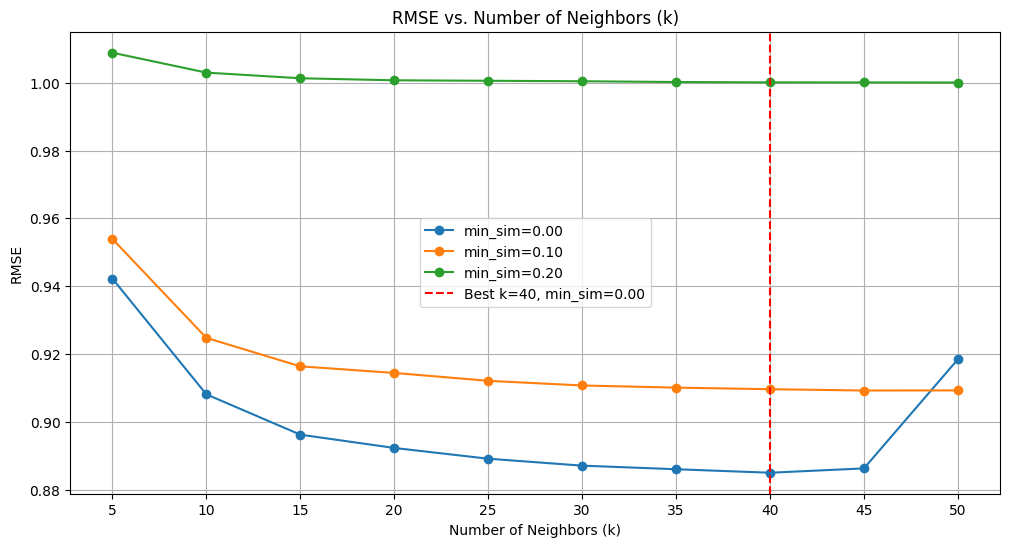

In [24]:
# Step 8: Visualize tuning results
tuning_plot = plot_tuning_results(results_df)
tuning_plot.savefig('tuning_results.png')

## Model evaluation

In [25]:
# Step 9: Evaluate final model
rmse, mae, coverage, eval_df = evaluate_model(
    test_long, similarity_df, train_matrix, best_k, best_min_sim)


Evaluating final model with k=40, min_similarity=0.0


188626it [03:33, 884.93it/s]



Final Evaluation Metrics:
RMSE: 0.8820
MAE: 0.6881
Coverage: 99.99%


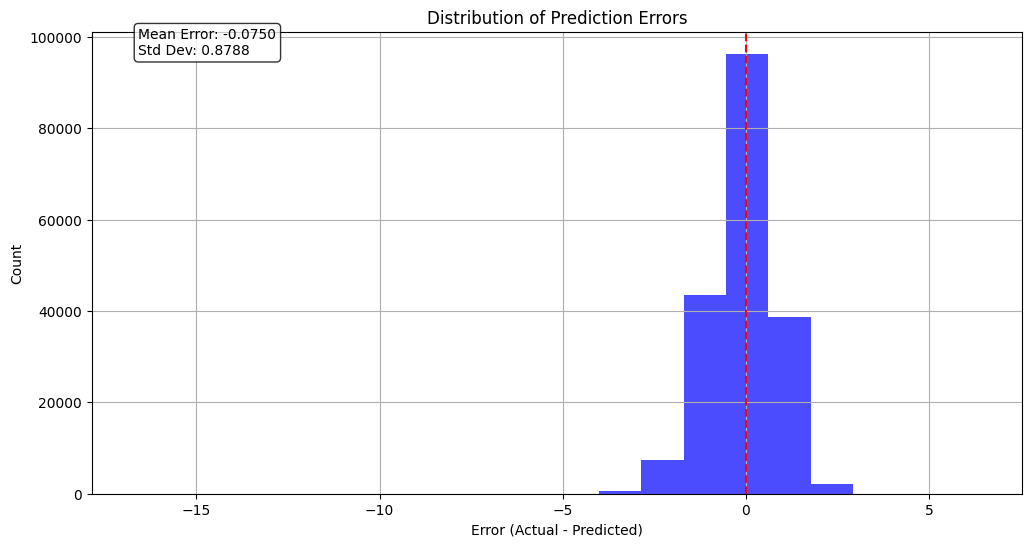

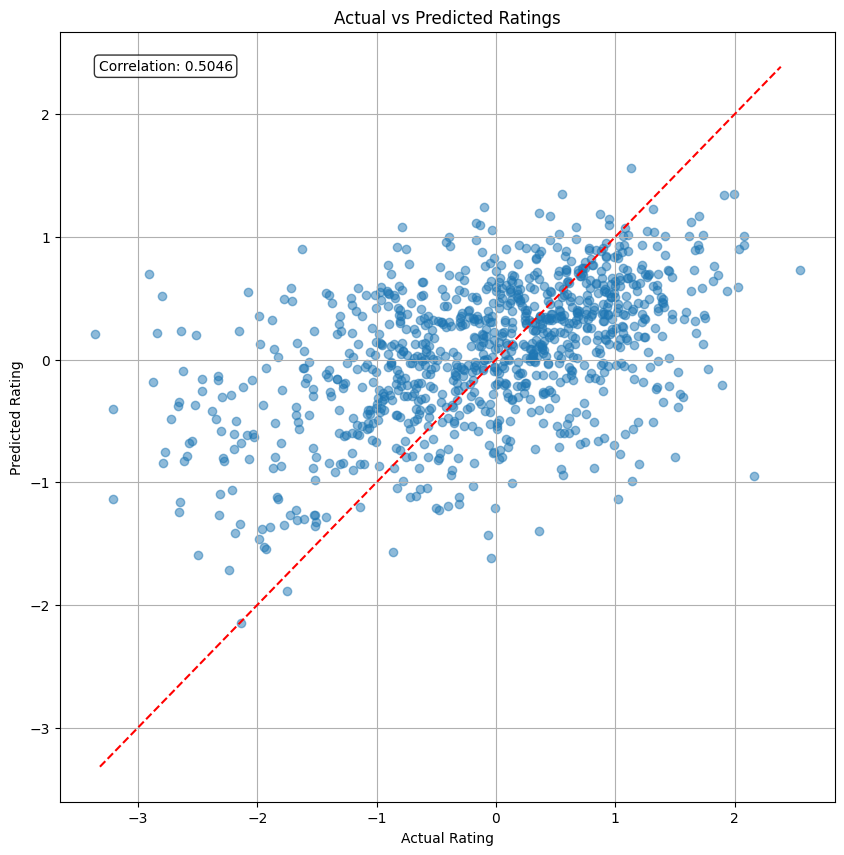

In [26]:
 # Step 10: Visualize evaluation results
if eval_df is not None:
    error_plot = plot_error_distribution(eval_df)
    error_plot.savefig('error_distribution.png')
        
    actual_vs_pred_plot = plot_actual_vs_predicted(eval_df)
    actual_vs_pred_plot.savefig('actual_vs_predicted.png')

In [27]:
# Step 11: Save model
best_params = {'k': best_k, 'min_similarity': best_min_sim}
metrics = {'rmse': rmse, 'mae': mae, 'coverage': coverage}
save_model(similarity_df, train_matrix, best_params, metrics)

print("UserKNN recommender system pipeline completed successfully")


Model saved to userknn_model.npz
UserKNN recommender system pipeline completed successfully
